In [13]:
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
import xgboost
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy import linspace
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, label_binarize
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, Lasso, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


In [118]:
# Read the cleaned data
trainDataOriginal = pd.read_csv('train_data.csv')
testDataOriginal = pd.read_csv('test_data.csv')

trainData = trainDataOriginal[trainDataOriginal['balls_remaining'] < 300]
testData = testDataOriginal[testDataOriginal['balls_remaining'] < 300]

# trainData = trainData[trainData['balls_remaining'] > 240]
# testData = trainData[trainData['balls_remaining'] > 240]

trainData = trainData[trainData['inning'] == 1]
testData = testData[testData['inning'] == 1]

In [119]:
def per_over_transformer(inputDF):
    outputDF = []
    outputDF.append(inputDF['innings_no'].iloc[0])
    outputDF.append(inputDF['inning'].iloc[0])
    outputDF.append(inputDF['runs'].sum())
    outputDF.append(inputDF['over'].iloc[-1])
    outputDF.append(inputDF['wicket'].sum())
    outputDF.append(inputDF['batting_team'].iloc[0])
    outputDF.append(inputDF['opponent'].iloc[0])
    outputDF.append(inputDF['wickets'].iloc[-1])
    outputDF.append(inputDF['current_score'].max())
    return pd.Series(outputDF, index=['innings_no', 'inning', 'runs_in_segment', 'over', 'wickets_in_segment', 
                               'batting_team', 'opponent', 'wickets', 'current_score'])

In [120]:
segment_size = 5
def segmenter(inputDF):
    outputDF = []
    outputDF.append(inputDF['innings_no'].iloc[0])
    outputDF.append(inputDF['inning'].iloc[0])
    outputDF.append(inputDF['runs_in_segment'].sum().astype(int))
    outputDF.append(np.ceil(inputDF['over'].iloc[-1] / segment_size).astype(int))
    outputDF.append(inputDF['wickets_in_segment'].sum())
    outputDF.append(inputDF['batting_team'].iloc[0])
    outputDF.append(inputDF['opponent'].iloc[0])
    outputDF.append(inputDF['wickets'].iloc[-1])
    outputDF.append(inputDF['current_score'].max())
    return pd.Series(outputDF, index=['innings_no', 'inning', 'runs_in_segment', 'over', 'wickets_in_segment', 
                               'batting_team', 'opponent', 'wickets', 'current_score'])

In [121]:
def segment_data(input_data):
    all_innings = input_data['innings_no'].unique()

    all_data = []
    for inning_id in all_innings:
        current_inning = input_data[input_data['innings_no'] == inning_id]

        per_over_data = current_inning.groupby(['over']).apply(per_over_transformer)
        per_over_data.reset_index(drop=True, inplace=True)
        segmented_data = per_over_data.groupby(per_over_data.index // segment_size).apply(segmenter)

        segmented_data['prev_seg_runs'] = segmented_data['runs_in_segment'].shift(1)
        segmented_data['prev_seg_wickets'] = segmented_data['wickets_in_segment'].shift(1)
        segmented_data['wickets_at_start'] = segmented_data['wickets'].shift(1)
        segmented_data['score_at_start'] = segmented_data['current_score'].shift(1)
        segmented_data = segmented_data.fillna(0)
    
        all_data.append(segmented_data)

    data = pd.concat(all_data, ignore_index=True)
    data.reset_index(drop=True, inplace=True)

    # Encode batting team and opponent
    encodedBattingTeam = pd.get_dummies(data['batting_team'], prefix='country');
    encodedOpponent = pd.get_dummies(data['opponent'], prefix='opponent');

    # Join the new columns with the original dataframe
    data = pd.concat([data, encodedBattingTeam], axis=1)
    data = pd.concat([data, encodedOpponent], axis=1)

    return data.drop(['batting_team', 'opponent', 'wickets', 'current_score'], axis=1)

In [122]:
segmented_train_data = segment_data(trainData)
segmented_test_data = segment_data(testData)

In [7]:
segmented_train_data.head()

,innings_no,inning,runs_in_segment,over,wickets_in_segment,prev_seg_runs,prev_seg_wickets,wickets_at_start,score_at_start,country_Australia,...,opponent_Australia,opponent_Bangladesh,opponent_England,opponent_India,opponent_New Zealand,opponent_Pakistan,opponent_South Africa,opponent_Sri Lanka,opponent_West Indies,opponent_Zimbabwe
0,0,1,24,1,0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,33,2,1,24.0,0.0,0.0,24.0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,9,3,2,33.0,1.0,1.0,57.0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,16,4,0,9.0,2.0,3.0,66.0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,27,5,0,16.0,0.0,3.0,82.0,0,...,0,0,0,0,0,0,0,1,0,0


In [256]:

rf = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=None, min_samples_split=2, 
                           min_samples_leaf=10, min_weight_fraction_leaf=0.001, max_features='auto', 
                           max_leaf_nodes=None, min_impurity_decrease=0, verbose=1)

multivariateReg = MultiOutputRegressor(rf)


xgb = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=12, subsample=0.01,
                           colsample_bytree=1, min_child_weight=0.001, silent=False, n_jobs=4)

rfc = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=0.0)

lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                        class_weight=None, random_state=None, solver='liblinear', max_iter=5000, 
                        multi_class='ovr', verbose=2)

mlp = MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='adam', alpha=0.0001, 
                    batch_size=2, learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                    max_iter=1000)

classifier = OneVsRestClassifier(rfc)


pipeline = Pipeline([
                ('standardizer', MinMaxScaler()),
                ('estimator', rf)
            ])

dropped_features = ['runs_in_segment', 'inning', 'innings_no', 'wickets_in_segment']
# dropped_features = ['runs_in_segment', 'inning', 'innings_no']

x_train = segmented_train_data.drop(dropped_features, axis=1)
# y_train = segmented_train_data[['runs_in_segment', 'wickets_in_segment']]
y_train = segmented_train_data['runs_in_segment']                                # <--- Uncomment this to predic runs
# y_train = pd.Series(segmented_train_data['wickets_in_segment'], dtype="category")  # <--- Uncomment this to predic wickets
# y_train_encoded = y = label_binarize(y_train, classes=list(range(0,7)))


x_test = segmented_test_data.drop(dropped_features, axis=1)
# y_test = segmented_test_data[['runs_in_segment', 'wickets_in_segment']]
y_test = segmented_test_data['runs_in_segment']                               # <--- Uncomment this to predic runs
# y_test = pd.Series(segmented_test_data['wickets_in_segment'], dtype="category") # <--- Uncomment this to predic wickets
# y_test_encoded = y = label_binarize(y_test, classes=list(range(0,7)))

pipeline.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   10.2s finished


Pipeline(memory=None,
     steps=[('standardizer', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.001, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=1, warm_start=False))])

In [257]:
y_hat = pipeline.predict(x_test)
# pipeline.score(x_test, y_test_encoded)

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [258]:
# Compare runs prediction
results = pd.DataFrame()

# results['actual'] = np.argmax(y_test_encoded, axis=1)
# results['prediction'] = np.argmax(y_hat, axis=1)

results['actual'] = y_test
results['prediction'] = y_hat

results.reset_index(drop=True, inplace=True)

mse = mean_squared_error(results['actual'], results['prediction']);
print('MSE', mse)
print('RMSE', np.sqrt(mse))

MSE 91.23734825997477
RMSE 9.551824341976499


In [259]:
results.head()

,actual,prediction
0,22,19.080657
1,23,27.055249
2,14,24.527892
3,24,19.753505
4,26,24.077008


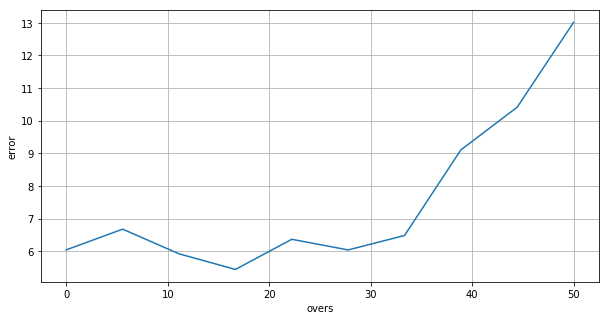

In [260]:
plt.figure(1, figsize = (10,5))
plt.xlabel('overs')
plt.ylabel('error')
t = linspace(0, 50, 10)

compare = pd.DataFrame()
compare['error'] = (results['actual'] - results['prediction']).abs()
compare['segment'] = segmented_test_data['over'] * 5
compare_per_segment = compare.groupby(['segment'], as_index=False).mean()

plt.plot(t, compare_per_segment['error'])
# plt.scatter(comparePerOver['balls'], comparePerOver['error'])


# PLot the datamining aproach results to comprae as our base model

# t = [0, 5, 10]
dmModel = [24, 25.5, 24, 23, 21, 20, 20, 18, 13.5, 8, 0]

baileyModel = [42, 40.5, 35, 32, 30, 26, 24, 20, 15, 11, 0]


# dmModel = [13.5, 8, 0]
overs = pd.DataFrame(t)
# plt.plot(t, dmModel)
# plt.plot(t, baileyModel)
plt.grid()
plt.show()

<Container object of 25 artists>

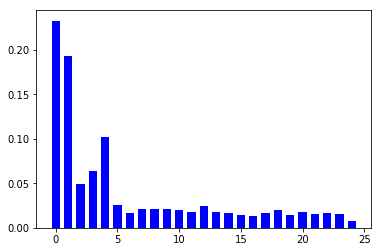

In [186]:
y = pipeline.named_steps['estimator'].feature_importances_
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width, color="blue")

In [28]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

In [154]:
y_hat

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])